In [19]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

In [2]:
def load_data(path, split_data=1):
    data = []
    labels = []
    listpath = os.listdir(path)
    total = len(listpath)
    for subpath in listpath:
        complete_subpath = os.path.join(path, subpath)
        images = os.listdir(complete_subpath)
        total_images = len(images)
        labels.extend([int(subpath) for _ in range(int(total_images*split_data))])
        for idx, image_name in enumerate(images[:int(total_images*split_data)]):
            image_path = os.path.join(complete_subpath, image_name)
            image = cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2GRAY).reshape(-1)
            data.append(image)
            print(f'Images: [{idx+1}/{int(total_images*split_data)}]> in label [{subpath}/{total-1}]', end='\r')
    return np.array(data), np.array(labels)

In [3]:
def one_hot(data, num_classes):
    new_data = np.zeros((data.shape[0], num_classes))
    new_data[np.arange(data.shape[0]), data] = 1
    return new_data

In [21]:
labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [4]:
path = r'datasets\fashion_mnist_images' # Complete the path
path_train = path + r'\train'
path_test = path + r'\test'

In [5]:
X_train, y_train = load_data(path_train)
X_test, y_test = load_data(path_test)

In [6]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [7]:
def ReLU(x, derv=False):
    if derv: return np.where(x>0, 1, 0)
    return np.maximum(x, 0)

In [8]:
def softmax(x, derv=False):
    x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    s = x_exp / x_exp.sum(axis=1, keepdims=True)
    if derv: return s * (1 - s)
    return s

In [ ]:
def CCE(y, y_pred, epsilon=1e-8, derv=False):
    if derv: return y_pred-y # In this case
    return -np.mean(y*np.log(y_pred+epsilon))

In [10]:
def accuracy(y, y_pred):
    return np.mean(np.argmax(y, axis=1)==np.argmax(y_pred, axis=1))

In [11]:
n_INPUTS = X_train.shape[1]
n_hidden1 = 256
n_hidden2 = 128
n_OUTPUTS = y_train.shape[1]

In [12]:
# Layer 1
W0 = np.random.randn(n_INPUTS, n_hidden1) * np.sqrt(2/n_INPUTS)
b0 = np.zeros((1, n_hidden1))

# Layer 2
W1 = np.random.randn(n_hidden1, n_hidden2) * np.sqrt(2/n_hidden1)
b1 = np.zeros((1, n_hidden2))

# Layer 3
W2 = np.random.randn(n_hidden2, n_OUTPUTS) * np.sqrt(2/n_hidden2)
b2 = np.zeros((1, n_OUTPUTS))

In [13]:
def forward(x):
    global z0, a0, z1, a1, z2, a2
    
    z0 = x @ W0 + b0
    a0 = ReLU(z0)
    
    z1 = a0 @ W1 + b1
    a1 = ReLU(z1)

    z2 = a1 @ W2 + b2
    a2 = softmax(z2)

    return a2

In [14]:
def update_params(dW0, db0, dW1, db1, dW2, db2, lr):
    global W0, W1, W2, b0, b1, b2

    W2 -= lr * dW2
    b2 -= lr * db2

    W1 -= lr * dW1
    b1 -= lr * db1

    W0 -= lr * dW0
    b0 -= lr * db0

In [15]:
def backward(x=None, y=None, outp=None, deltas=None, learn=True, lr=0.01):
    if y is not None:
        dL = CCE(y, outp, derv=True)
    elif deltas is not None:
        dL = deltas
    else: raise ValueError('There is no (y) or (deltas).')
    # dL *= softmax(z2, derv=True)
    m = dL.shape[0]

    dW2 = a1.T @ dL / m
    db2 = dL.sum(axis=0, keepdims=True) / m

    da1 = dL @ W2.T
    dz1 = da1 * ReLU(z1, derv=True)

    dW1 = a0.T @ dz1 / m
    db1 = dz1.sum(axis=0, keepdims=True) / m

    da0 = dz1 @ W1.T
    dz0 = da0 * ReLU(z0, derv=True)

    dW0 = x.T @ dz0 / m
    db0 = dz0.sum(axis=0, keepdims=True) / m

    deltas = dz0 @ W0.T

    if learn:
        update_params(dW0, db0, dW1, db1, dW2, db2, lr)
    
    return deltas, dW0, dW1, dW2, db0, db1, db2

In [16]:
def train(x, y, epochs=150, batch_size=128, lr=0.005, print_every=0.1):
    for epoch in range(1, epochs+1):
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        
        for batch in range(0, x.shape[0], batch_size):
            x_batch = x[batch:batch+batch_size]
            y_batch = y[batch:batch+batch_size]

            predictions = forward(x_batch)
            backward(x_batch, y_batch, predictions, learn=True, lr=lr)

        if epoch % max(1, int(epochs * print_every)) == 0:
            loss = CCE(y, forward(x))
            acc = accuracy(y, forward(x))
            print(f'Epochs: [{epoch}/{epochs}]> Loss: {loss:.4f} | Acc: {acc:.4f}')

In [ ]:
train(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=128,
    lr=0.005,
    print_every=0.1
)

Epochs: [15/150]> Loss: 0.0421 | Acc: 0.8556
Epochs: [30/150]> Loss: 0.0376 | Acc: 0.8706
Epochs: [45/150]> Loss: 0.0341 | Acc: 0.8821
Epochs: [60/150]> Loss: 0.0320 | Acc: 0.8885
Epochs: [75/150]> Loss: 0.0302 | Acc: 0.8947
Epochs: [90/150]> Loss: 0.0282 | Acc: 0.9016
Epochs: [105/150]> Loss: 0.0272 | Acc: 0.9042
Epochs: [120/150]> Loss: 0.0258 | Acc: 0.9094
Epochs: [135/150]> Loss: 0.0258 | Acc: 0.9077
Epochs: [150/150]> Loss: 0.0249 | Acc: 0.9103


In [18]:
accuracy(y_test, forward(X_test))

np.float64(0.8755)

Prediction: Dress | Real: Dress


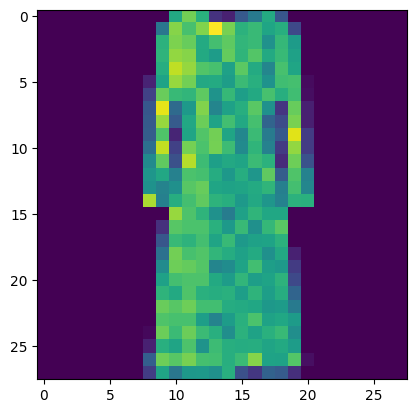

In [54]:
random_idx = np.random.randint(0, X_test.shape[0])
random_image, true_label = X_test[random_idx], labels[np.argmax(y_test[random_idx])]
prediction = labels[np.argmax(forward(random_image))]
print(f'Prediction: {prediction} | Real: {true_label}')
plt.imshow(random_image.reshape(28, 28))
plt.show()